In [1]:
import pandas as pd
import numpy as np
from scipy.interpolate import CubicSpline
import matplotlib.pyplot as plt

In [2]:
import gurobipy as gp
from gurobipy import GRB

options = {
    "WLSACCESSID": "31598bc4-0b23-474f-86d4-af032d437137",
    "WLSSECRET": "bd7ad348-f8d6-452e-b615-ebc88d920e41",
    "LICENSEID": 2498404,
}

In [3]:
df = pd.read_csv('data_20180119_20180420.csv', index_col=0)
df.head()

,t0,T1,K1,C1,T2,K2,C2,S0,Adj_S0
0,2018-01-02,2018-01-19,1000.0,191.525,2018-04-20,800.0,396.725000,59.4505,1189.01001
1,2018-01-02,2018-01-19,1100.0,92.525,2018-04-20,1015.0,191.675000,59.4505,1189.01001
2,2018-01-02,2018-01-19,1150.0,46.075,2018-04-20,1025.0,183.025000,59.4505,1189.01001
3,2018-01-02,2018-01-19,1160.0,38.000,2018-04-20,1050.0,157.776341,59.4505,1189.01001
4,2018-01-02,2018-01-19,1170.0,30.450,2018-04-20,1080.0,137.850000,59.4505,1189.01001


In [4]:
t0List = list(df.t0.unique())

In [26]:
NList = [5, 10, 15, 20, 25, 30, 35, 40, 50]

### Linear Programming Problem
min $d+\sum_{n=1}^{N_1}\lambda_{n,1}\Pi_{n,1}+\sum_{n=1}^{N_2}\lambda_{n,2}\Pi_{n,2}$

s.t. $d+\sum_{n=1}^{N_1}\lambda_{n,1}(S_1^i-K_{n,1})^++\sum_{n=1}^{N_2}\lambda_{n,2}(S_2^j-K_{n,2})^++\Delta_{0}\cdot(S_1^i-S_0)+\Delta_{1}^i\cdot(S_2^j-S_1^i) \geq \Phi(S_1^i,S_2^j), i,j=1,...,N$

In [6]:
def payoff(S1,S2):
    return max(S2 - S1, 0)

In [7]:
stocks = pd.read_csv('adjusted_stocks.csv')
realS1 = stocks.loc[stocks.Date=='2018-01-19', 'AMZN'].item()
realS2 = stocks.loc[stocks.Date=='2018-04-20', 'AMZN'].item()

In [19]:
def params_N(df, t0List, N):
    parameters = {}
    
    for t0 in t0List:
        df_t0 = df.loc[df.t0 == t0].copy()
        
        C1 = df_t0['C1']
        C2 = df_t0['C2']
        K1 = df_t0['K1']
        K2 = df_t0['K2']
        
        S0 = df_t0['Adj_S0'].unique()
        # Adjustment of I_ref
        I_ref = 50
        d_S1, u_S1 = min(K1)-I_ref, max(K1)+I_ref
        d_S2, u_S2 = min(K2)-I_ref, max(K2)+I_ref
        while realS1 > u_S1:
            u_S1 += I_ref
        while realS1 < d_S1:
            d_S1 -= I_ref
        while realS2 > u_S2:
            u_S2 += I_ref
        while realS2 < d_S2:
            d_S2 -= I_ref
        S1 = np.linspace(d_S1, u_S1, N)
        S2 = np.linspace(d_S2, u_S2, N)
        
        m = gp.Model("Price Bounds")
        d = m.addVars(['d'], name="d")
        lamb1 = m.addVars(df_t0.index, name="lamb1")
        lamb2 = m.addVars(df_t0.index, name="lamb2")
        delta0 = m.addVars(['delta0'], name="delta0")
        delta1 = m.addVars(np.array(S1).flatten(), name="delta1")
        
        m.setObjective(d['d']+sum(lamb1[r]*C1[r]+lamb2[r]*C2[r] for r in df_t0.index))
        m.ModelSense = GRB.MINIMIZE
        
        for S1_i in S1:
            for S2_j in S2:
                m.addConstr(d['d'] + sum(lamb1[r]*max(S1_i-K1[r],0)+lamb2[r]*max(S2_j-K2[r],0) for r in df_t0.index) + 
                            delta0['delta0']*(S1_i-S0) + delta1[S1_i]*(S2_j-S1_i)
                            >= payoff(S1_i, S2_j), 'C_{}{}'.format(S1_i, S2_j))
                m.update()
        
        m.optimize()
        
        if m.status == GRB.OPTIMAL:
            var = {v.varName: v.x for v in m.getVars()}
            
            delta1_values = np.array([var['delta1[{}]'.format(s1)] for s1 in S1])
            delta1_interpolator = CubicSpline(S1, delta1_values)
            
            parameters[t0] = {
                'd': var['d[d]'],
                'lamb1': {r: var['lamb1[{}]'.format(r)] for r in df_t0.index},
                'lamb2': {r: var['lamb2[{}]'.format(r)] for r in df_t0.index},
                'delta0': var['delta0[delta0]'],
                'delta1': delta1_interpolator
            }
        else:
            print("Optimization was not successful.")
        
    return parameters

In [20]:
def hedgingStrategy(parameters, S0, K1, K2):
    h = (parameters[t0]['d']
         + sum(parameters[t0]['lamb1'][r] * max(realS1-K1[r],0) + 
               parameters[t0]['lamb2'][r] * max(realS2-K2[r],0) for r in df_t0.index)
         + parameters[t0]['delta0'] * (realS1 - S0)
         + parameters[t0]['delta1'](realS1) * (realS2-realS1)
        )
    return h

In [21]:
hMatrix = np.zeros((len(NList), len(t0List)))

In [27]:
for i in range(len(NList)):
    N = NList[i]
    parameters = params_N(df, t0List, N)
    for j in range(len(t0List)):
        t0 = t0List[j]
        df_t0 = df.loc[df.t0 == t0].copy()
        S0 = df_t0['Adj_S0'].unique()
        K1 = df_t0['K1']
        K2 = df_t0['K2']
        h = hedgingStrategy(parameters, S0, K1, K2)
        
        hMatrix[i,j] = h

Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.5.0 23F79)

CPU model: Apple M2
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 25 rows, 47 columns and 515 nonzeros
Model fingerprint: 0x7212290e
Coefficient statistics:
  Matrix range     [1e+00, 8e+02]
  Objective range  [8e-01, 4e+02]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e+01, 7e+02]
Presolve removed 0 rows and 4 columns
Presolve time: 0.00s
Presolved: 25 rows, 43 columns, 495 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   1.507812e+02   0.000000e+00      0s
      12    1.3587302e+02   0.000000e+00   0.000000e+00      0s

Solved in 12 iterations and 0.00 seconds (0.00 work units)
Optimal objective  1.358730159e+02
Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.5.0 23F79)

CPU model: Apple M2
Thread count: 8 physical cores, 8 logical processors, using up to 8 thre

      10    1.0518695e+02   0.000000e+00   0.000000e+00      0s

Solved in 10 iterations and 0.00 seconds (0.00 work units)
Optimal objective  1.051869550e+02
Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.5.0 23F79)

CPU model: Apple M2
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 25 rows, 47 columns and 580 nonzeros
Model fingerprint: 0x74ecadb1
Coefficient statistics:
  Matrix range     [1e+00, 6e+02]
  Objective range  [5e-01, 2e+02]
  Bounds range     [0e+00, 0e+00]
  RHS range        [4e+01, 4e+02]
Presolve removed 0 rows and 2 columns
Presolve time: 0.00s
Presolved: 25 rows, 45 columns, 570 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   1.427344e+02   0.000000e+00      0s
       9    1.0181969e+02   0.000000e+00   0.000000e+00      0s

Solved in 9 iterations and 0.00 seconds (0.00 work units)
Optimal objective  1.018196856e+02
Gurobi Optimizer ve


Solved in 25 iterations and 0.00 seconds (0.00 work units)
Optimal objective  1.047620505e+02
Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.5.0 23F79)

CPU model: Apple M2
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 100 rows, 52 columns and 2309 nonzeros
Model fingerprint: 0xb4315cfb
Coefficient statistics:
  Matrix range     [1e+00, 6e+02]
  Objective range  [9e-01, 3e+02]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e+00, 4e+02]
Presolve time: 0.00s
Presolved: 100 rows, 52 columns, 2309 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   3.949653e+02   0.000000e+00      0s
      22    1.1712838e+02   0.000000e+00   0.000000e+00      0s

Solved in 22 iterations and 0.00 seconds (0.00 work units)
Optimal objective  1.171283840e+02
Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.5.0 23F79)

CPU model: Apple M2
Thread coun

       0    0.0000000e+00   1.405603e+03   0.000000e+00      0s
      43    9.7665984e+01   0.000000e+00   0.000000e+00      0s

Solved in 43 iterations and 0.01 seconds (0.00 work units)
Optimal objective  9.766598412e+01
Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.5.0 23F79)

CPU model: Apple M2
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 225 rows, 57 columns and 5174 nonzeros
Model fingerprint: 0xc609bc72
Coefficient statistics:
  Matrix range     [1e+00, 6e+02]
  Objective range  [2e-01, 3e+02]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e+00, 5e+02]
Presolve removed 1 rows and 0 columns
Presolve time: 0.00s
Presolved: 224 rows, 57 columns, 5150 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   1.125357e+03   0.000000e+00      0s
      39    1.0947710e+02   0.000000e+00   0.000000e+00      0s

Solved in 39 iterations and 0.01 seconds (0.


Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   2.138158e+03   0.000000e+00      0s
      45    1.4581406e+02   0.000000e+00   0.000000e+00      0s

Solved in 45 iterations and 0.01 seconds (0.00 work units)
Optimal objective  1.458140635e+02
Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.5.0 23F79)

CPU model: Apple M2
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 400 rows, 62 columns and 11000 nonzeros
Model fingerprint: 0x67821105
Coefficient statistics:
  Matrix range     [1e-02, 8e+02]
  Objective range  [4e-01, 2e+02]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 6e+02]
Presolve time: 0.00s
Presolved: 400 rows, 62 columns, 11000 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   2.547911e+03   0.000000e+00      0s
      42    1.0586358e+02   0.000000e+00   0.000000e+00      0s

Solved in 42 it

  Bounds range     [0e+00, 0e+00]
  RHS range        [2e+00, 4e+02]
Presolve time: 0.00s
Presolved: 400 rows, 62 columns, 9379 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   2.210757e+03   0.000000e+00      0s
      43    1.0297310e+02   0.000000e+00   0.000000e+00      0s

Solved in 43 iterations and 0.01 seconds (0.00 work units)
Optimal objective  1.029731016e+02
Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.5.0 23F79)

CPU model: Apple M2
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 400 rows, 62 columns and 10699 nonzeros
Model fingerprint: 0xa8a11163
Coefficient statistics:
  Matrix range     [1e-01, 7e+02]
  Objective range  [3e-02, 2e+02]
  Bounds range     [0e+00, 0e+00]
  RHS range        [5e+00, 6e+02]
Presolve removed 1 rows and 0 columns
Presolve time: 0.00s
Presolved: 399 rows, 62 columns, 10682 nonzeros

Iteration    Objective       Prima

  Matrix range     [2e-13, 6e+02]
  Objective range  [9e-01, 3e+02]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e+00, 4e+02]
         Consider reformulating model or setting NumericFocus parameter
         to avoid numerical issues.
Presolve removed 1 rows and 0 columns
Presolve time: 0.01s
Presolved: 624 rows, 67 columns, 14333 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   2.411719e+03   0.000000e+00      0s
      43    1.1711758e+02   0.000000e+00   0.000000e+00      0s

Solved in 43 iterations and 0.01 seconds (0.01 work units)
Optimal objective  1.171175840e+02
Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.5.0 23F79)

CPU model: Apple M2
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 625 rows, 67 columns and 15474 nonzeros
Model fingerprint: 0x642934d5
Coefficient statistics:
  Matrix range     [6e-01, 6e+02]
  Objective range  [6e-01, 3e

         to avoid numerical issues.
Presolve time: 0.01s
Presolved: 900 rows, 72 columns, 22380 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   5.818222e+03   0.000000e+00      0s
      64    9.7739731e+01   0.000000e+00   0.000000e+00      0s

Solved in 64 iterations and 0.01 seconds (0.01 work units)
Optimal objective  9.773973144e+01
Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.5.0 23F79)

CPU model: Apple M2
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 900 rows, 72 columns and 20820 nonzeros
Model fingerprint: 0xf8098645
Coefficient statistics:
  Matrix range     [4e-01, 6e+02]
  Objective range  [2e-01, 3e+02]
  Bounds range     [0e+00, 0e+00]
  RHS range        [7e-01, 5e+02]
Presolve time: 0.01s
Presolved: 900 rows, 72 columns, 20820 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   4.377284e+0

  Matrix range     [2e-13, 8e+02]
  Objective range  [8e-01, 4e+02]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e+00, 7e+02]
         Consider reformulating model or setting NumericFocus parameter
         to avoid numerical issues.
Presolve removed 1 rows and 0 columns
Presolve time: 0.01s
Presolved: 1224 rows, 77 columns, 25269 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   6.613051e+03   0.000000e+00      0s
      78    1.4584873e+02   0.000000e+00   0.000000e+00      0s

Solved in 78 iterations and 0.01 seconds (0.01 work units)
Optimal objective  1.458487324e+02
Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.5.0 23F79)

CPU model: Apple M2
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 1225 rows, 77 columns and 33740 nonzeros
Model fingerprint: 0x85af3a8b
Coefficient statistics:
  Matrix range     [3e-01, 8e+02]
  Objective range  [4e-01, 


Solved in 88 iterations and 0.01 seconds (0.01 work units)
Optimal objective  1.052772313e+02
Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.5.0 23F79)

CPU model: Apple M2
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 1225 rows, 77 columns and 28805 nonzeros
Model fingerprint: 0x9d41b94b
Coefficient statistics:
  Matrix range     [3e-01, 6e+02]
  Objective range  [5e-01, 2e+02]
  Bounds range     [0e+00, 0e+00]
  RHS range        [7e-01, 4e+02]
Presolve time: 0.01s
Presolved: 1225 rows, 77 columns, 28805 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   6.876163e+03   0.000000e+00      0s
      72    1.0298226e+02   0.000000e+00   0.000000e+00      0s

Solved in 72 iterations and 0.01 seconds (0.01 work units)
Optimal objective  1.029822632e+02
Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.5.0 23F79)

CPU model: Apple M2
Thread 

  RHS range        [3e-01, 7e+02]
Presolve time: 0.01s
Presolved: 1600 rows, 82 columns, 38039 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   1.326431e+04   0.000000e+00      0s
     102    1.0503330e+02   0.000000e+00   0.000000e+00      0s

Solved in 102 iterations and 0.02 seconds (0.02 work units)
Optimal objective  1.050332955e+02
Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.5.0 23F79)

CPU model: Apple M2
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 1600 rows, 82 columns and 36916 nonzeros
Model fingerprint: 0x225edd39
Coefficient statistics:
  Matrix range     [3e-01, 6e+02]
  Objective range  [9e-01, 3e+02]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 4e+02]
Presolve removed 2 rows and 0 columns
Presolve time: 0.01s
Presolved: 1598 rows, 82 columns, 36846 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time

GurobiError: Model too large for size-limited license; visit https://gurobi.com/unrestricted for more information

In [23]:
gapMatrix = hMatrix - payoff(realS1, realS2)

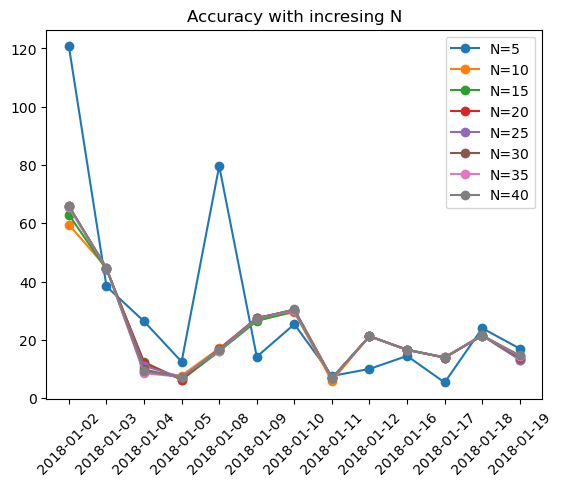

In [25]:
for i in range(len(NList)):
    plt.plot(t0List, gapMatrix[i, :], '-o', label=f'N={NList[i]}')
plt.xticks(rotation=45)
plt.legend()
plt.title('Accuracy with incresing N')
plt.show()